<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    Data Preparation
</h1>

<h3 style="color:#555; text-align:left;">
    Handling mIssing values, outliers detection tratment, codification (categrical values), normalization, feature engineering and feature selection
</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

# **1: Data importation**

In [545]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
src_path = project_root / "src"
sys.path.append(str(src_path))

from utils_data import load_df, quick_overview

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats
from scipy.stats import chi2_contingency # filter method

from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LogisticRegression #(This is one possible model to apply inside RFE)
from sklearn.linear_model import LassoCV # embedded method
from sklearn.tree import DecisionTreeClassifier # embedded method



In [546]:
MASTER_NAME = "telco_master"

df = load_df(MASTER_NAME, folder="processed")
print(f"\nLoaded '{MASTER_NAME}' from processed with shape: {df.shape}")

📂 Loaded: C:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\data\processed\telco_master.csv

Loaded 'telco_master' from processed with shape: (7043, 56)


# **2: Data Separation: Hold-Out Method**

In [547]:
cols_to_drop = ['st_customer_status','st_churn_label', 'st_churn_value']

X = df.drop(columns=cols_to_drop, axis = 1)
y = df['st_churn_value'].copy()

In [548]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}:")
    
    print("X_train: Nº index =", train_index.shape[0])
    print("train_index head(5) =", train_index[:5])
    
    print("X_test: Nº index =", test_index.shape[0])
    print("test_index head(5) =", test_index[:5])
    
    print("-" * 30)

Fold 1:
X_train: Nº index = 5634
train_index head(5) = [0 1 2 4 5]
X_test: Nº index = 1409
test_index head(5) = [ 3  6  7 11 15]
------------------------------
Fold 2:
X_train: Nº index = 5634
train_index head(5) = [0 1 2 3 5]
X_test: Nº index = 1409
test_index head(5) = [ 4  9 10 25 33]
------------------------------
Fold 3:
X_train: Nº index = 5634
train_index head(5) = [0 1 2 3 4]
X_test: Nº index = 1409
test_index head(5) = [ 8 12 14 26 28]
------------------------------
Fold 4:
X_train: Nº index = 5635
train_index head(5) = [0 1 3 4 6]
X_test: Nº index = 1408
test_index head(5) = [ 2  5 13 16 17]
------------------------------
Fold 5:
X_train: Nº index = 5635
train_index head(5) = [2 3 4 5 6]
X_test: Nº index = 1408
test_index head(5) = [ 0  1 21 22 23]
------------------------------


# **3: Data Cleaning**
## **3.1 Outliers**

## **3.2 Handling Missing Values**

In [549]:
#Handle meaningful missing values in categoricals
# Fill missing values with explicit categories where appropriate
fill_map = {}

if "svc_offer" in X.columns:
    fill_map["svc_offer"] = "No Offer"

if "svc_internet_type" in X.columns:
    fill_map["svc_internet_type"] = "No Internet"

if "st_churn_category" in X.columns:
    fill_map["st_churn_category"] = "Not Churned"

if "st_churn_reason" in X.columns:
    fill_map["st_churn_reason"] = "Not Churned"

X = df.fillna(value=fill_map)

# Quick check
X[["svc_offer", "svc_internet_type", "st_churn_category", "st_churn_reason"]].head()


,svc_offer,svc_internet_type,st_churn_category,st_churn_reason
0,No Offer,DSL,Competitor,Competitor offered more data
1,Offer E,Fiber Optic,Competitor,Competitor made better offer
2,Offer D,Fiber Optic,Competitor,Competitor made better offer
3,Offer C,Fiber Optic,Dissatisfaction,Limited range of services
4,Offer C,Fiber Optic,Price,Extra data charges


# **4: Data Transformation**
## **4.1: Creating new variables**
### **4.1.1: variable "Is_womam"**

In [550]:
X["demo_gender"].value_counts(dropna=False)

demo_gender
Male      3555
Female    3488
Name: count, dtype: int64

In [551]:
X["Is_woman"] = X["demo_gender"].map({"Male": 0, "Female": 1})


In [552]:
X["Is_woman"].value_counts(dropna=False)

Is_woman
0    3555
1    3488
Name: count, dtype: int64

### **4.1.2: variable "Has_offer"**

In [553]:
X["svc_offer"].value_counts(dropna=False)

svc_offer
No Offer    3877
Offer B      824
Offer E      805
Offer D      602
Offer A      520
Offer C      415
Name: count, dtype: int64

In [554]:
X["Has_offer"] = X["svc_offer"].map({"No Offer": 0, "Offer A": 1, "Offer B": 1, "Offer C": 1, "Offer D": 1, "Offer E": 1})

In [555]:
X["Has_offer"].value_counts(dropna=False)

Has_offer
0    3877
1    3166
Name: count, dtype: int64

## **4.2: Misclassification**

In [556]:
#Ensure Yes/No consistency

binary_cols = [
    "demo_under_30",
    "demo_senior_citizen",
    "demo_married",
    "demo_dependents",
    "svc_referred_a_friend",
    "svc_phone_service",
    "svc_multiple_lines",
    "svc_internet_service",
    "svc_online_security",
    "svc_online_backup",
    "svc_device_protection_plan",
    "svc_premium_tech_support",
    "svc_streaming_tv",
    "svc_streaming_movies",
    "svc_streaming_music",
    "svc_unlimited_data",
    "svc_paperless_billing",
]

# Standardize Yes/No → Yes/No
for col in binary_cols:
    if col in X.columns:
        X[col] = X[col].astype(str).str.strip().str.title()  # e.g., "yes" → "Yes"

# Quick check
print("Columns corrected:")
for col in binary_cols:
    if col in df.columns:
        print(col, df[col].unique())

Columns corrected:
demo_under_30 ['No' 'Yes']
demo_senior_citizen ['Yes' 'No']
demo_married ['No' 'Yes']
demo_dependents ['No' 'Yes']
svc_referred_a_friend ['No' 'Yes']
svc_phone_service ['No' 'Yes']
svc_multiple_lines ['No' 'Yes']
svc_internet_service ['Yes' 'No']
svc_online_security ['No' 'Yes']
svc_online_backup ['No' 'Yes']
svc_device_protection_plan ['Yes' 'No']
svc_premium_tech_support ['No' 'Yes']
svc_streaming_tv ['No' 'Yes']
svc_streaming_movies ['Yes' 'No']
svc_streaming_music ['No' 'Yes']
svc_unlimited_data ['No' 'Yes']
svc_paperless_billing ['Yes' 'No']


## **4.3: Binning**

In [557]:
binary_cols = [
    "demo_under_30",
    "demo_senior_citizen",
    "demo_married",
    "demo_dependents",
    "svc_referred_a_friend",
    "svc_phone_service",
    "svc_multiple_lines",
    "svc_internet_service",
    "svc_online_security",
    "svc_online_backup",
    "svc_device_protection_plan",
    "svc_premium_tech_support",
    "svc_streaming_tv",
    "svc_streaming_movies",
    "svc_streaming_music",
    "svc_unlimited_data",
    "svc_paperless_billing",
]

# Convert Yes/No → 1/0
for col in binary_cols:
    if col in X.columns:
        X[col] = X[col].map({"Yes": 1, "No": 0})

# Quick check
print("Binary columns converted to 0/1:")
for col in binary_cols:
    if col in X.columns:
        print(col, X[col].unique())

Binary columns converted to 0/1:
demo_under_30 [0 1]
demo_senior_citizen [1 0]
demo_married [0 1]
demo_dependents [0 1]
svc_referred_a_friend [0 1]
svc_phone_service [0 1]
svc_multiple_lines [0 1]
svc_internet_service [1 0]
svc_online_security [0 1]
svc_online_backup [0 1]
svc_device_protection_plan [1 0]
svc_premium_tech_support [0 1]
svc_streaming_tv [0 1]
svc_streaming_movies [1 0]
svc_streaming_music [0 1]
svc_unlimited_data [0 1]
svc_paperless_billing [1 0]


## **4.4: Ordinal encoding and create dummy variables**
### **4.4.1: svc_offer**

In [558]:
X["svc_internet_type"].value_counts(dropna=False)

svc_internet_type
Fiber Optic    3035
DSL            1652
No Internet    1526
Cable           830
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Escolhe as colunas categóricas a codificar
categorical_cols = ["svc_internet_type", "svc_contract","svc_payment_method"]

# Subset
X_cat = X[categorical_cols]

# Criar encoder
encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)

# Fit só no treino
encoder.fit(X_train[categorical_cols])

# Transformar
X_cat_encoded = encoder.transform(X_cat)

# Criar nomes das colunas novas
new_col_names = encoder.get_feature_names_out(categorical_cols)

# Converter para DataFrame
X_cat_encoded_df = pd.DataFrame(X_cat_encoded,
                                columns=new_col_names,
                                index=X.index)

# Remover as colunas originais e juntar as novas
X_final = pd.concat([X.drop(columns=categorical_cols), X_cat_encoded_df], axis=1)


In [526]:
X.head()

,demo_count,demo_age,demo_under_30,demo_senior_citizen,demo_married,demo_dependents,demo_number_of_dependents,loc_count,loc_zip_code,loc_latitude,loc_longitude,svc_count,svc_referred_a_friend,svc_number_of_referrals,svc_tenure_in_months,svc_phone_service,svc_avg_monthly_long_distance_charges,svc_multiple_lines,svc_internet_service,svc_avg_monthly_gb_download,svc_online_security,svc_online_backup,svc_device_protection_plan,svc_premium_tech_support,svc_streaming_tv,svc_streaming_movies,svc_streaming_music,svc_unlimited_data,svc_paperless_billing,svc_monthly_charge,svc_total_charges,svc_total_refunds,svc_total_extra_data_charges,svc_total_long_distance_charges,svc_total_revenue,st_count,st_satisfaction_score,st_churn_value,st_churn_score,st_cltv,zip_population,Is_woman,Has_offer,demo_gender_Female,demo_gender_Male,loc_country_United States,loc_state_California,loc_city_Acampo,loc_city_Acton,loc_city_Adelanto,...,"loc_lat_long_41.962127, -122.527696",svc_quarter_Q3,svc_offer_No Offer,svc_offer_Offer A,svc_offer_Offer B,svc_offer_Offer C,svc_offer_Offer D,svc_offer_Offer E,svc_internet_type_Cable,svc_internet_type_DSL,svc_internet_type_Fiber Optic,svc_contract_Month-to-Month,svc_contract_One Year,svc_contract_Two Year,svc_payment_method_Bank Withdrawal,svc_payment_method_Credit Card,svc_payment_method_Mailed Check,st_quarter_Q3,st_customer_status_Churned,st_customer_status_Joined,st_customer_status_Stayed,st_churn_label_No,st_churn_label_Yes,st_churn_category_Attitude,st_churn_category_Competitor,st_churn_category_Dissatisfaction,st_churn_category_Not Churned,st_churn_category_Other,st_churn_category_Price,st_churn_reason_Attitude of service provider,st_churn_reason_Attitude of support person,st_churn_reason_Competitor had better devices,st_churn_reason_Competitor made better offer,st_churn_reason_Competitor offered higher download speeds,st_churn_reason_Competitor offered more data,st_churn_reason_Deceased,st_churn_reason_Don't know,st_churn_reason_Extra data charges,st_churn_reason_Lack of affordable download/upload speed,st_churn_reason_Lack of self-service on Website,st_churn_reason_Limited range of services,st_churn_reason_Long distance charges,st_churn_reason_Moved,st_churn_reason_Network reliability,st_churn_reason_Not Churned,st_churn_reason_Poor expertise of online support,st_churn_reason_Poor expertise of phone support,st_churn_reason_Price too high,st_churn_reason_Product dissatisfaction,st_churn_reason_Service dissatisfaction
0,1,78,0,1,0,0,0,1,90022,34.023810,-118.156582,1,0,0,1,0,0.00,0,1,8,0,0,1,0,0,1,0,0,1,39.65,39.65,0.00,20,0.00,59.65,1,3,1,91,5433,68701,0,0,False,True,True,True,False,False,False,...,False,True,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,74,0,1,1,1,1,1,90063,34.044271,-118.185237,1,1,1,8,1,48.85,1,1,17,0,1,0,0,0,0,0,1,1,80.65,633.30,0.00,0,390.80,1024.10,1,3,1,69,5302,55668,1,1,True,False,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,True,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1,71,0,1,0,1,3,1,90065,34.108833,-118.229715,1,0,0,18,1,11.33,1,1,52,0,0,0,0,1,1,1,1,1,95.45,1752.55,45.61,0,203.94,1910.88,1,2,1,81,3179,47534,0,1,False,True,True,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1,78,0,1,1,1,1,1,90303,33.936291,-118.332639,1,1,1,25,1,19.76,0,1,12,0,1,1,0,1,1,0,1

### **4.4.2: svc_internet type**

In [520]:
X["svc_internet_service"].value_counts(dropna=False)

svc_internet_service
1    5517
0    1526
Name: count, dtype: int64

### **4.4.3: svc_contract**

### **4.4.4: svc_payment method**

## **4.5: Feature Engineering**

# **5: Data Reduction**
## **5.1: Repeated Information, Unary or nearly unary variables**

In [ ]:
#based on EDA conclusions, drop unneeded columns
cols_to_drop = [
    "loc_country",
    "demo_count",
    "loc_count",
    "loc_state",
    "svc_count",
    "st_count",
    "svc_quarter",
    "st_quarter",
    "st_churn_label",
    "st_churn_score",
    "loc_city",
    "loc_lat_long",
    "demo_gender",
    "svc_offer",
]

# Drop only those that exist (defensive)
existing_to_drop = [c for c in cols_to_drop if c in X.columns]

X = X.drop(columns=existing_to_drop)

print("Dropped columns:", existing_to_drop)
print("New shape:", X.shape)


Dropped columns: ['loc_country', 'demo_count', 'loc_count', 'loc_state', 'svc_count', 'st_count', 'svc_quarter', 'st_quarter', 'st_churn_score', 'loc_city', 'loc_lat_long', 'demo_gender']
New shape: (7043, 42)


## **5.3: Multicollinearity - Check correlation**

In [428]:
#based on business understanding, drop more columns
cols_to_drop = [
    "st_satisfaction_score",
    "st_cltv",
    "st_churn_category",
    "st_churn_reason",
]

# Drop only those that exist (defensive)
existing_to_drop = [c for c in cols_to_drop if c in X.columns]

X = X.drop(columns=existing_to_drop)

print("Dropped columns:", existing_to_drop)
print("New shape:", X.shape)


Dropped columns: ['st_satisfaction_score', 'st_cltv', 'st_churn_category', 'st_churn_reason']
New shape: (7043, 39)


In [385]:
# Data Type Summary + Small-Cardinality Category Check
# Step: Summarize data types
dtype_summary = (
    X.dtypes
    .reset_index()
    .rename(columns={'index': 'column', 0: 'dtype'})
    .sort_values('dtype')
)

print("=== Data Type Summary ===")
display(dtype_summary)


# Step: Identify categorical columns AFTER cleaning
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("\n=== Categorical Columns ===")
print(cat_cols)



# Step: Show unique values for categorical columns with <5 unique entries
print("\n=== Categorical Variables with <5 Unique Values ===")
for col in cat_cols:
    unique_vals = X[col].unique()
    if len(unique_vals) <= 5:
        print(f"\nColumn: {col}  (unique={len(unique_vals)})")
        print(unique_vals)

        



=== Data Type Summary ===


,column,dtype
21,svc_online_backup,int64
38,st_cltv,int64
37,st_satisfaction_score,int64
34,svc_total_extra_data_charges,int64
29,svc_paperless_billing,int64
27,svc_unlimited_data,int64
26,svc_streaming_music,int64
25,svc_streaming_movies,int64
24,svc_streaming_tv,int64
23,svc_premium_tech_support,int64



=== Categorical Columns ===
['demo_gender', 'svc_offer', 'svc_internet_type', 'svc_contract', 'svc_payment_method', 'st_churn_category', 'st_churn_reason']

=== Categorical Variables with <5 Unique Values ===

Column: demo_gender  (unique=2)
['Male' 'Female']

Column: svc_internet_type  (unique=4)
['DSL' 'Fiber Optic' 'Cable' nan]

Column: svc_contract  (unique=3)
['Month-to-Month' 'One Year' 'Two Year']

Column: svc_payment_method  (unique=3)
['Bank Withdrawal' 'Credit Card' 'Mailed Check']


In [386]:
# Step: Identify numerical columns AFTER cleaning
num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

print("\n=== Numerical Columns ===")
print(num_cols)


=== Numerical Columns ===
['demo_age', 'demo_under_30', 'demo_senior_citizen', 'demo_married', 'demo_dependents', 'demo_number_of_dependents', 'loc_zip_code', 'loc_latitude', 'loc_longitude', 'svc_referred_a_friend', 'svc_number_of_referrals', 'svc_tenure_in_months', 'svc_phone_service', 'svc_avg_monthly_long_distance_charges', 'svc_multiple_lines', 'svc_internet_service', 'svc_avg_monthly_gb_download', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'svc_monthly_charge', 'svc_total_charges', 'svc_total_refunds', 'svc_total_extra_data_charges', 'svc_total_long_distance_charges', 'svc_total_revenue', 'st_satisfaction_score', 'st_cltv', 'zip_population', 'Is male?']


## **5.4: Summary**

In [387]:
def classify_columns(df):
    binary_cols = []
    ordinal_cols = []
    continuous_cols = []
    object_cols = []

    for col in df.columns:
        # --- 1) Columns with object dtype (strings, categories)
        if df[col].dtype == "object":
            object_cols.append(col)
            continue

        # --- 2) Numeric columns ---
        # Check unique values ignoring NaNs
        unique_vals = df[col].dropna().unique()

        # 2A) Binary categorical (only 0 and 1)
        if set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2:
            binary_cols.append(col)
            continue

        # 2B) Ordinal numeric: integers & more than 2 categories
        if pd.api.types.is_integer_dtype(df[col]):
            ordinal_cols.append(col)
            continue

        # 2C) Continuous numeric: floats
        if pd.api.types.is_float_dtype(df[col]):
            continuous_cols.append(col)
            continue

        # 2D) Fallback → treat as object
        object_cols.append(col)

    return binary_cols, ordinal_cols, continuous_cols, object_cols


binary_cols, ordinal_cols, continuous_cols, object_cols = classify_columns(X)

print("Binary:", binary_cols)
print("Ordinal:", ordinal_cols)
print("Continuous:", continuous_cols)
print("Object:", object_cols)

Binary: ['demo_under_30', 'demo_senior_citizen', 'demo_married', 'demo_dependents', 'svc_referred_a_friend', 'svc_phone_service', 'svc_multiple_lines', 'svc_internet_service', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'Is male?']
Ordinal: ['demo_age', 'demo_number_of_dependents', 'loc_zip_code', 'svc_number_of_referrals', 'svc_tenure_in_months', 'svc_avg_monthly_gb_download', 'svc_total_extra_data_charges', 'st_satisfaction_score', 'st_cltv', 'zip_population']
Continuous: ['loc_latitude', 'loc_longitude', 'svc_avg_monthly_long_distance_charges', 'svc_monthly_charge', 'svc_total_charges', 'svc_total_refunds', 'svc_total_long_distance_charges', 'svc_total_revenue']
Object: ['demo_gender', 'svc_offer', 'svc_internet_type', 'svc_contract', 'svc_payment_method', 'st_churn_category', 'st_churn_reason']


In [410]:
def get_unique_values(df, col_type, binary_cols, ordinal_cols, continuous_cols, object_cols):
    # Map the keyword to the correct list
    mapping = {
        "binary": binary_cols,
        "ordinal": ordinal_cols,
        "continuous": continuous_cols,
        "object": object_cols
    }
    
    if col_type not in mapping:
        raise ValueError("Invalid column type. Use: 'binary', 'ordinal', 'continuous', 'object'.")
    
    selected_cols = mapping[col_type]
    
    # Build dictionary with unique values for every column
    unique_dict = {col: df[col].dropna().unique() for col in selected_cols}
    
    return unique_dict


In [412]:
unique_binary = get_unique_values(X, "binary", binary_cols, ordinal_cols, continuous_cols, object_cols)
print("Unique values in binary columns:",unique_binary)


Unique values in binary columns: {'demo_under_30': array([0, 1]), 'demo_senior_citizen': array([1, 0]), 'demo_married': array([0, 1]), 'demo_dependents': array([0, 1]), 'svc_referred_a_friend': array([0, 1]), 'svc_phone_service': array([0, 1]), 'svc_multiple_lines': array([0, 1]), 'svc_internet_service': array([1, 0]), 'svc_online_security': array([0, 1]), 'svc_online_backup': array([0, 1]), 'svc_device_protection_plan': array([1, 0]), 'svc_premium_tech_support': array([0, 1]), 'svc_streaming_tv': array([0, 1]), 'svc_streaming_movies': array([1, 0]), 'svc_streaming_music': array([0, 1]), 'svc_unlimited_data': array([0, 1]), 'svc_paperless_billing': array([1, 0])}


In [413]:
unique_ordinal = get_unique_values(X, "ordinal", binary_cols, ordinal_cols, continuous_cols, object_cols)
print("Unique values in binary columns:",unique_ordinal)

Unique values in binary columns: {'demo_age': array([78, 74, 71, 80, 72, 76, 66, 70, 77, 65, 67, 68, 69, 79, 75, 73, 37,
       19, 31, 23, 38, 21, 29, 61, 27, 20, 56, 51, 48, 32, 34, 41, 30, 26,
       62, 64, 45, 53, 63, 42, 24, 54, 39, 43, 50, 22, 40, 47, 60, 52, 55,
       59, 49, 58, 25, 28, 33, 44, 57, 46, 36, 35]), 'demo_number_of_dependents': array([0, 1, 3, 2, 5, 4, 6, 7, 8, 9]), 'loc_zip_code': array([90022, 90063, 90065, ..., 91934, 92105, 92250], shape=(1626,)), 'svc_number_of_referrals': array([ 0,  1,  6,  2,  4,  3,  7,  5,  8,  9, 10, 11]), 'svc_tenure_in_months': array([ 1,  8, 18, 25, 37, 27, 58, 15,  7, 11,  3, 13, 16, 24,  4, 32, 54,
        2, 21, 55,  5, 20, 65, 49, 43, 56, 52, 33, 30, 46,  9, 10, 35, 44,
       62, 14, 12, 17, 39, 68, 34, 22, 19, 23, 42, 41, 57, 38, 29, 66, 69,
       40, 31, 59, 36, 45, 53, 70, 47, 50, 51, 72, 26,  6, 28, 48, 61, 71,
       60, 64, 67, 63]), 'svc_avg_monthly_gb_download': array([ 8, 17, 52, 12, 14, 18, 30, 24, 19, 29, 28, 11,  9

In [ ]:
unique_binary = get_unique_values(X, "binary", binary_cols, ordinal_cols, continuous_cols, object_cols)
unique_ordinal = get_unique_values(X, "ordinal", binary_cols, ordinal_cols, continuous_cols, object_cols)
unique_object  = get_unique_values(X, "object", binary_cols, ordinal_cols, continuous_cols, object_cols)


# **6: Feature Selection**
## **6.1: Filter Methods**
### **6.1.1 Chi-Square [Categorical data]**

In [388]:
def apply_chisquare(X, y, var, alpha=0.05):
    dfObserved = pd.crosstab(y, X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [389]:
def select_best_cat_features(X, y):
    count = 1

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    \n')

        # check which features to use using chi-square
        X_train_cat= X_train.select_dtypes(include=['object', 'category']).copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var], y_train, var)

        count+=1

In [390]:
select_best_cat_features(X, y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    

demo_gender is NOT an important predictor. (Discard demo_gender from model)
svc_offer is IMPORTANT for Prediction
svc_internet_type is IMPORTANT for Prediction
svc_contract is IMPORTANT for Prediction
svc_payment_method is IMPORTANT for Prediction
st_churn_category is NOT an important predictor. (Discard st_churn_category from model)
st_churn_reason is NOT an important predictor. (Discard st_churn_reason from model)
_________________________________________________________________________________________________

                                     SPLIT 2                                    

demo_gender is NOT an important predictor. (Discard demo_gender from model)
svc_offer is IMPORTANT for Prediction
svc_internet_type is IMPORTANT for Prediction
svc_contract is IMPORTANT for Prediction
svc_payment_metho

### **6.1.2: Variance [Continuous, ordinal and binary data]**

In [391]:
def apply_variance(X_train, var):
  print(var + ':' + str(X_train.var()))

In [392]:
def select_features_variance(X, y):
    count = 1
    numerical_columns = X.select_dtypes(include=[np.number]).columns
    #print(numerical_columns)

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #################################### SELECT FEATURES WITH VARIANCE ########################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    \n')

        # check which features to use using variance
        for var in numerical_columns:
          apply_variance(X_train[var], var)

        count+=1

In [393]:
select_features_variance(X, y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    

demo_age:280.35909970915975
demo_under_30:0.15769139851807654
demo_senior_citizen:0.13629459015446088
demo_married:0.24985756068393802
demo_dependents:0.17943100022743658
demo_number_of_dependents:0.9421566872178823
loc_zip_code:3425162.0391192464
loc_latitude:6.114729547053709
loc_longitude:4.669553964454211
svc_referred_a_friend:0.24847743856392687
svc_number_of_referrals:8.87729236551104
svc_tenure_in_months:602.8952492982646
svc_phone_service:0.08552547456507405
svc_avg_monthly_long_distance_charges:238.70886694743328
svc_multiple_lines:0.2447217418577995
svc_internet_service:0.16927884712034366
svc_avg_monthly_gb_download:422.5453427463964
svc_online_security:0.2041395975248802
svc_online_backup:0.22586464178174143
svc_device_protection_plan:0.22586464178174148
svc_premium_tech_support:0.206837074567115

| Combination | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
| --- | --- | --- | --- | --- | --- |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |

### **6.1.3. Spearman Correlation [Continuous and ordinal data]**

In [394]:
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [395]:
def apply_correlation(X_train):
    correlation_data = X_train#.drop(['Dependents'], axis = 1).copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only = True)
    cor_heatmap(matrix)

In [396]:
def redundant_features(X, y):
    count = 1

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    \n')

        # check which features to use using spearman correlation
        apply_correlation(X_train)

        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    



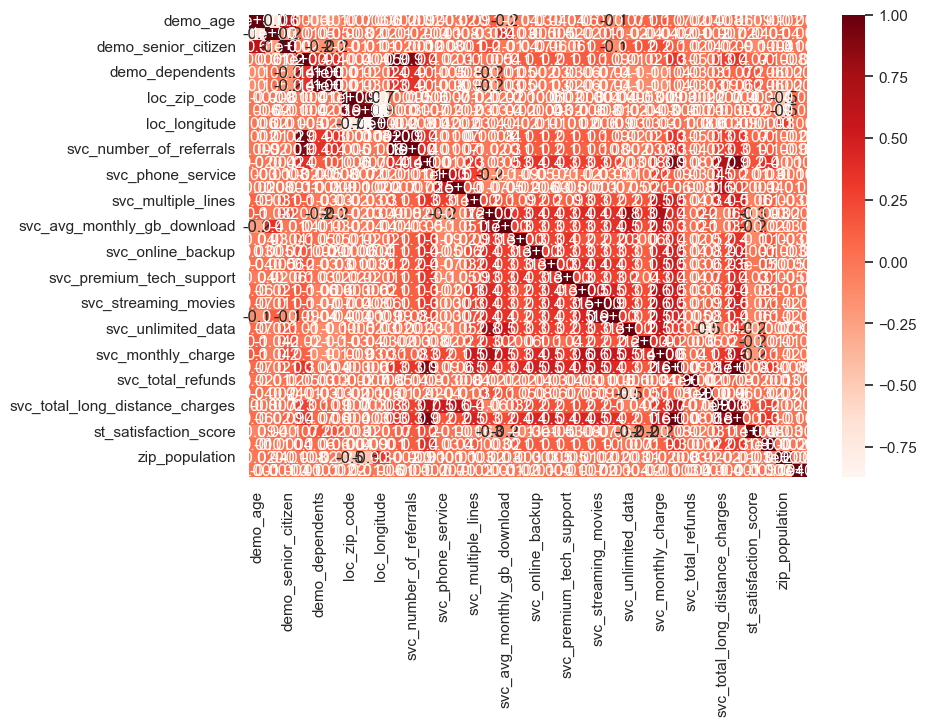

_________________________________________________________________________________________________

                                     SPLIT 2                                    



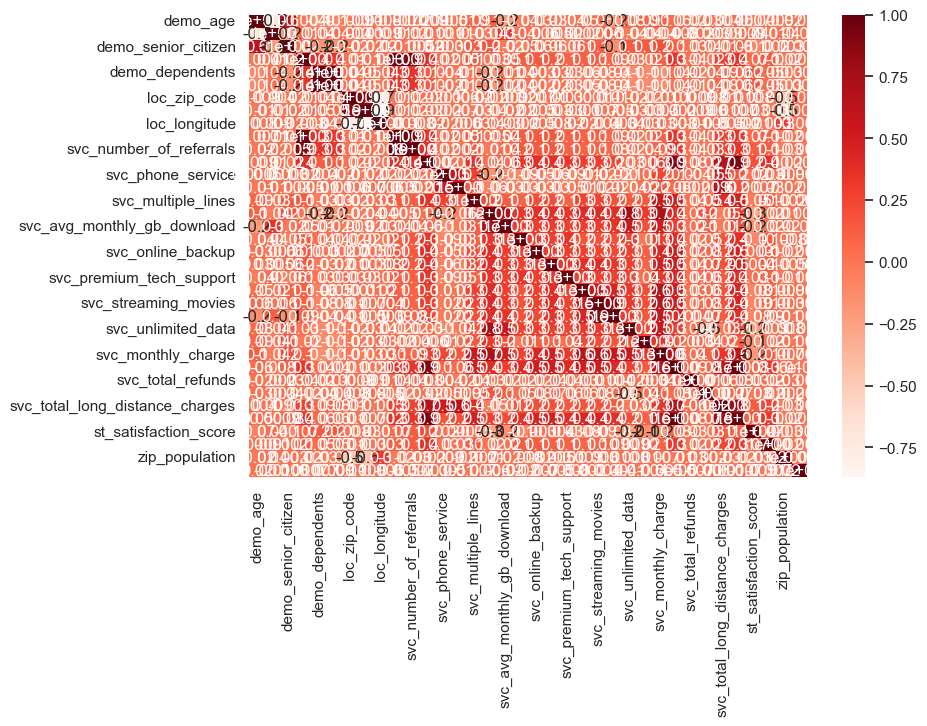

_________________________________________________________________________________________________

                                     SPLIT 3                                    



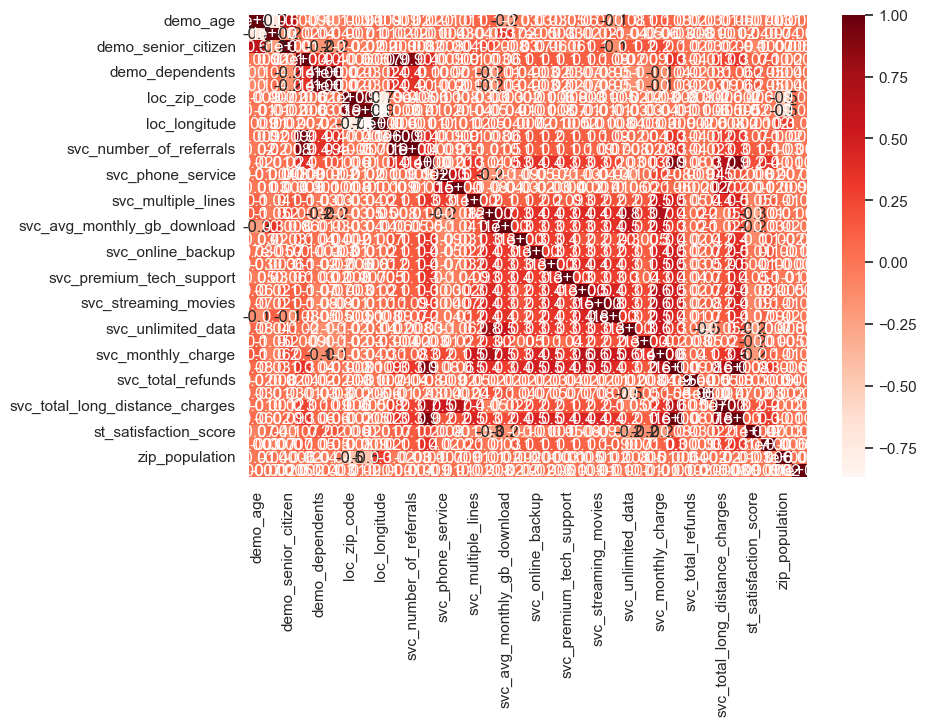

_________________________________________________________________________________________________

                                     SPLIT 4                                    



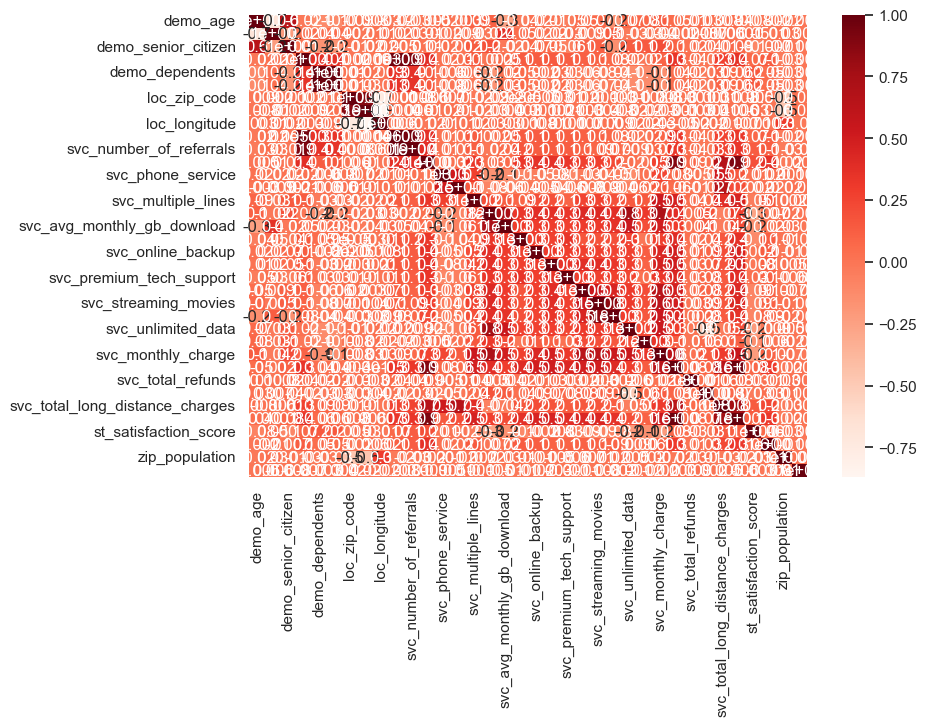

_________________________________________________________________________________________________

                                     SPLIT 5                                    



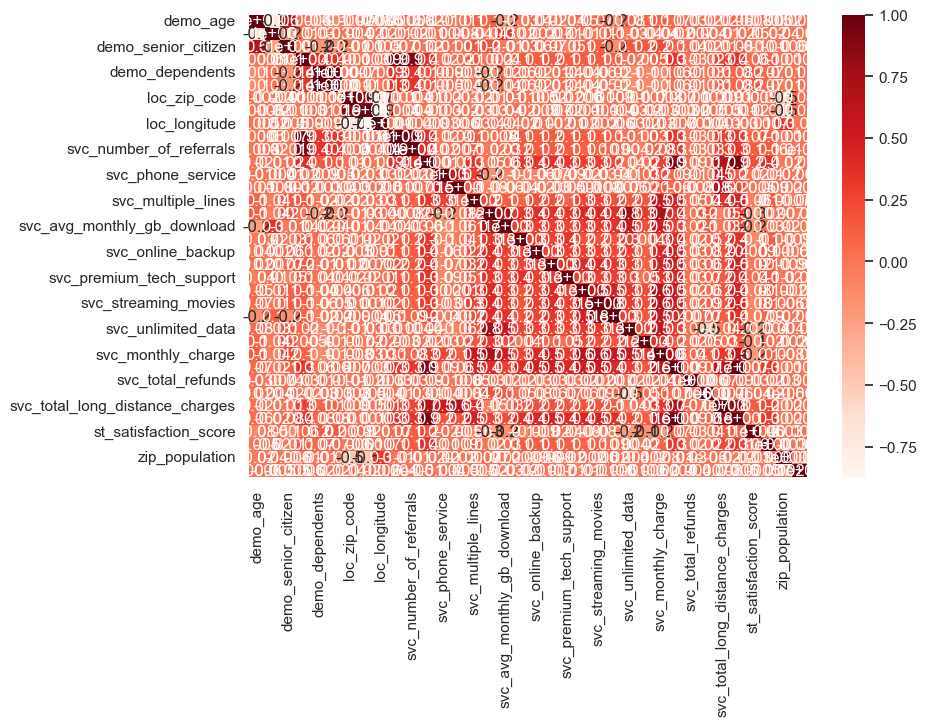

In [397]:
redundant_features(X, y)

__Redundant Variables__ - Spearman Correlation higher than |0.8|

| Combination | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
| --- | --- | --- | --- | --- | --- |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |

## **6.2 Embedded Methods**
### **6.2.1 Decidision Trees [Continuous, ordinal and binary data]**

In [398]:
def plot_importance(variables, name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [399]:
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns)
    plot_importance(feature_importances, 'DT')

In [400]:
def select_best_features_dt(X, y):
    count = 1

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    \n')

        # check which features to use using decision Tree
        X_train = X_train #.drop(['Marital_Status'], axis = 1)
        apply_dt(X_train, y_train)

        count+=1

In [401]:
select_best_features_dt(X, y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    



ValueError: could not convert string to float: 'Male'